## Part I: Optimal span for LOESS

### Objective

Write your own function to employ LOO-CV and GCV in selecting the optimal span for LOESS. Definitions of LOO-CV and GCV can be found on page 33 of [[lec_W5_NonlinearRegression.pdf]](https://liangfgithub.github.io/Notes/lec_W5_NonlinearRegression.pdf)

### Task
1. Test your code using data set [Coding3_Data.csv]
2. Report your CV and GCV for the following 15 span values: 0.20, 0.25, . . . , 0.90.
3. Report the optimal span value(s) based on CV and GCV.
4. Display the original data points and overlay them with the true curve and the fitted curve(s) generated using the optimal span value(s).

The true curve is
$$
    f(x) = \frac{sin[12(x + 0.2)]}{x + 0.2}
$$

**Note:** Your plot may differ from the one provided below. You’re encouraged to use your own color schemes and styles.


In [1]:
from skmisc.loess import loess

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import plotly.graph_objects as go


### Steps

**Computing the Diagonal of the Smoother Matrix:** 

Create a function to retrieve the diagonal of the smoother matrix. We’re only interested in the diagonal entries (which will be used in computing LOO-CV and GCV), so this function should return an n-by-1 vector.

- Inputs: x (an n-by-1 feature vector) and span (a numerical value).
- Output: n-by-1 vector representing the diagonal of the smoother matrix S.
- Tip: Review the technique we used for the smoother matrix in smoothing spline models and adapt it for LOESS.

In [2]:

# Load the data from the provided CSV file
data_url = "https://liangfgithub.github.io/Data/Coding3_Data.csv"
data = pd.read_csv(data_url)
x = data['x'].values
y = data['y'].values

In [3]:
def retrieve_diagnoal_of_smooth_matrix(x: np.ndarray,
                                      span:float) -> np.ndarray:
    n = len(x)
    Y = np.identity(n)
    result = np.zeros(n) 
    for i in range(n):
        result[i] = loess(x, Y[i,:], span=span).predict(x).values[i]
    return result

**Span Value Iteration**

- Iterate over the specified span values.
- For each span, calculate the CV and GCV values.
- Post iteration, compile lists of CV and GCV values corresponding to each span.
- Determine the best span based on the CV and GCV results. It’s possible for both methods to recommend the same span.
- The leave-one-out(LOO)-CV and Generalized CV formula are in [[lec_W5_NonlinearRegression.pdf]](https://liangfgithub.github.io/Notes/lec_W5_NonlinearRegression.pdf), Page 33

In [4]:
# Function to perform LOO-CV/Generalized CV for a given span
def cross_validation(x: np.ndarray, 
                     y: np.ndarray, 
                     span: float) -> tuple[float, float]:
   n = len(x)
   g_hat = loess(x, y, span=span).predict(x).values
   error = y - g_hat
   S = retrieve_diagnoal_of_smooth_matrix(x, span)
   trace_S = np.sum(S)
   loo_cv_res = 0
   gcv_res = 0
   for i in range(n):
      loo_cv_res += (error[i]/(1 - S[i]))**2
      gcv_res += (error[i]/(1 - trace_S/n))**2
   
   return loo_cv_res/n, gcv_res/n

In [5]:
loocv_values = []
gcv_values = []
span_values = np.arange(0.20, 0.95, 0.05)
for span in span_values:
    loocv_val, gcv_val = cross_validation(x, y, span)
    loocv_values.append(loocv_val)
    gcv_values.append(gcv_val)


result_dict = {'Span': span_values,
          'loocv': loocv_values,
          'gcv': gcv_values}

result_df = pd.DataFrame(result_dict)

print(result_df)

# Find the optimal span based on CV and GCV
optimal_span_loocv = span_values[np.argmin(loocv_values)]
optimal_span_gcv = span_values[np.argmin(gcv_values)]

print()
print("Optimal Span of LOOCV is: {0:1.2f}".format(optimal_span_loocv))
print("Optimal Span of GCV is: {0:1.2f}".format(optimal_span_gcv))
print("The optimal span overall is {0: 1.2f}".format(optimal_span_gcv))


    Span      loocv       gcv
0   0.20  12.415911  2.110162
1   0.25   2.241473  1.489206
2   0.30   1.502980  1.190110
3   0.35   1.259175  1.174423
4   0.40   1.190380  1.102540
5   0.45   1.156812  1.062503
6   0.50   1.125652  1.041833
7   0.55   1.179664  1.118841
8   0.60   1.179464  1.119269
9   0.65   1.250914  1.180585
10  0.70   1.553562  1.519091
11  0.75   1.636175  1.627429
12  0.80   1.764534  1.744549
13  0.85   1.976094  1.925696
14  0.90   2.035108  1.979820

Optimal Span of LOOCV is: 0.50
Optimal Span of GCV is: 0.50
The optimal span overall is  0.50


### Generate final results and plotting them

In [6]:
new_x = np.linspace(min(x), max(x), 100)
true_y = np.sin(12 *(new_x + 0.2))/(new_x + 0.2)
fitted_y = loess(x, y, span=0.5).predict(new_x).values

In [7]:
fig = go.Figure()
fig.update_layout(width=1000,height=500,
                 xaxis_title="x", yaxis_title="Y")

fig.add_trace(go.Scatter(x=x, y=y,
                mode='markers',
                name= 'Raw Data',
                marker_symbol='circle-open',
                marker_size =10,
                marker_color="red"))

fig.add_trace(go.Scatter(x=new_x, y=true_y,
                name= 'True curve',
                line=dict(color='grey')))

fig.add_trace(go.Scatter(x=new_x, y=fitted_y,
                name= 'Fitted curve',
                line=dict(color='blue', dash='dash')))


Text(0, 0.5, 'CV Score')

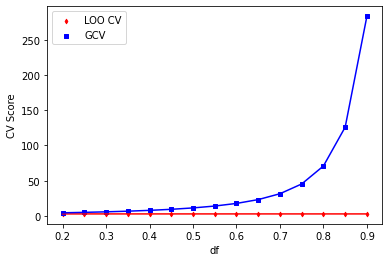

In [12]:
dfs = span_values
m = len(dfs)
my_lcv = np.zeros(m)
my_gcv = np.zeros(m)
for i in range(m):
    df = dfs[i]
    my_gcv[i] = gcv(x, y, df)
    my_lcv[i] = loo_cv(x, y, df)
plt.plot(dfs, my_lcv, color='red')
plt.scatter(dfs, my_lcv, color='red', marker='d', s=10, label='LOO CV')
plt.plot(dfs, my_gcv, color='blue')
plt.scatter(dfs, my_gcv, color='blue', marker='s', s=10, label='GCV')
plt.legend()
plt.xlabel("df")
plt.ylabel("CV Score")